In [1]:
import drawsvg as dw
from os import listdir
dir = '/home/jh/src/svg/lib'
files = listdir(dir)
for file in files:
    if file[-3:] == '.py':
        f = '%s/%s' % (dir,file)
        exec(open(f).read())

In [2]:
import os.path
import shutil
import site

import notebook

# Copy csoundmagics in site-packages dir
dest = site.getsitepackages()[0]
print(dest)
#shutil.copy("csoundmagics.py", dest)

# Copy csound mode in codemirror
dest = os.path.join(notebook.DEFAULT_STATIC_FILES_PATH, "components", "codemirror", "mode", "csound")
if not os.path.exists(dest):
    os.mkdir(dest)
print(dest)
#shutil.copy("csound.js", dest)

# Copy custom.js in jupyter dir
dest = os.path.join(notebook.extensions.jupyter_config_dir(), "custom")
if not os.path.exists(dest):
    os.mkdir(dest)
print(dest)
#shutil.copy("custom.js", dest)

help(notebook)

/usr/local/lib/python3.9/dist-packages
/usr/lib/python3/dist-packages/notebook/static/components/codemirror/mode/csound
/home/jh/.jupyter/custom
Help on package notebook:

NAME
    notebook - The Jupyter HTML Notebook

PACKAGE CONTENTS
    __main__
    _sysinfo
    _tz
    _version
    auth (package)
    base (package)
    bundler (package)
    config_manager
    edit (package)
    extensions
    files (package)
    gateway (package)
    i18n (package)
    jstest
    kernelspecs (package)
    log
    nbconvert (package)
    nbextensions
    notebook (package)
    notebookapp
    prometheus (package)
    serverextensions
    services (package)
    terminal (package)
    transutils
    tree (package)
    utils
    view (package)

DATA
    DEFAULT_NOTEBOOK_PORT = 8888
    DEFAULT_STATIC_FILES_PATH = '/usr/lib/python3/dist-packages/notebook/s...
    DEFAULT_TEMPLATE_PATH_LIST = ['/usr/lib/python3/dist-packages/notebook...
    version_info = (6, 2, 0)

VERSION
    6.2.0

FILE
    /usr/lib/p

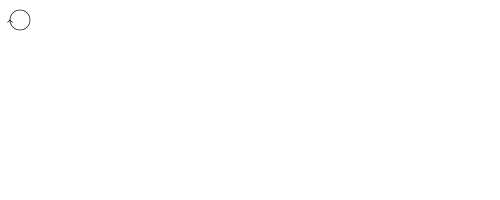

In [4]:
d = dw.Drawing(500,200)

def kreisLinks(x=20,y=20,r=10,swfac=1,c='black',**args):
    """ein kreis mit pfeil nach links
    sw = swfac * r / 15
    x,y ist mitte des kreises"""
    sw = swfac * r / 15
    alen = r/2
    d.append(dw.Circle(x,y,r,fill='none',stroke=c,stroke_width=sw,**args))
    d.append(dw.Lines(x+r-alen/2,y+alen/2, x+r,y ,x+r+alen/2,y+alen/2,fill='none',stroke=c,stroke_width=sw,**args))

def kreisRechts(x=20,y=20,r=10,swfac=1,c='black',**args):
    """ein kreis mit pfeil nach rechts
    sw = swfac * r / 15
    x,y ist mitte des kreises"""
    sw = swfac * r / 15
    alen = r/2
    d.append(dw.Circle(x,y,r,fill='none',stroke=c,stroke_width=sw,**args))
    d.append(dw.Lines(x-r-alen/2,y+alen/2, x-r,y ,x-r+alen/2,y+alen/2,fill='none',stroke=c,stroke_width=sw,**args))
    
    
kreisRechts()
#d.set_pixel_scale(4)
d